<a href="https://colab.research.google.com/github/jonatapaulino/Recurrent-Neural-Network-LSTM/blob/master/Ana%CC%81lise_Sentimento_Tweets_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importações

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Model
from keras.callbacks import Callback
from keras import backend as K

from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
#from keras import backend

import re, os

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import normalize

import matplotlib
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Configurações Iniciais

In [58]:
seed = 7
seed = np.random.seed(seed)

# O model será exportado para este arquivo
#filename='C:/analisesentimentoLSTM/model/model_saved.h5'
filename='/content/drive/My Drive/Redes LSTM FINAL/model'

epochs = 30
# dimensionalidade do word embedding pré-treinado
word_embedding_dim = 50

# número de amostras a serem utilizadas em cada atualização do gradiente
batch_size = 40

# Reflete a quantidade máxima de palavras que iremos manter no vocabulário
max_fatures = 6000

# dimensão de saída da camada Embedding
embed_dim = 128

# limitamos o tamanho máximo de todas as sentenças
max_sequence_length = 300

pre_trained_wv = True

bilstm = False

## Funções

In [50]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    cleanr = re.compile('<.*?>')
    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')

    return string.strip().lower()


In [51]:
def prepare_data(data):
    
    data = data[['texto', 'sentimento']]

    data['texto'] = data['texto'].apply(lambda x: x.lower())
    data['texto'] = data['texto'].apply(lambda x: clean_str(x))
    data['texto'] = data['texto'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    
    stop_words = set(stopwords.words('portuguese'))
    text = []
    for row in data["texto"].values:
        word_list = text_to_word_sequence(row)
        no_stop_words = [w for w in word_list if not w in stop_words]
        no_stop_words = " ".join(no_stop_words)
        text.append(no_stop_words)


    tokenizer = Tokenizer(num_words=max_fatures, split=' ')

    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)  
    
    X = pad_sequences(X, maxlen=max_sequence_length)
    #X = pad_sequences(X)

    word_index = tokenizer.word_index
    Y = pd.get_dummies(data['sentimento']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

    return X_train, X_test, Y_train, Y_test, word_index, tokenizer

In [52]:
def load_pre_trained_wv(word_index, num_words, word_embedding_dim):
    embeddings_index = {}
    f = open(os.path.join('/content/drive/My Drive/Redes LSTM FINAL/word_embedding/glove.6B.50d.txt'.format(word_embedding_dim)), encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('%s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((num_words, word_embedding_dim))
    for word, i in word_index.items():
        if i >= max_fatures:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

### Modelo

In [53]:
def build_model():
    if pre_trained_wv is True:
        print("USE PRE TRAINED")
        num_words = min(max_fatures, len(word_index) + 1)
        weights_embedding_matrix = load_pre_trained_wv(word_index, num_words, word_embedding_dim)
        input_shape = (max_sequence_length,)
        model_input = Input(shape=input_shape, name="input", dtype='int32')    
        embedding = Embedding(
            num_words, 
            word_embedding_dim,
            input_length=max_sequence_length, 
            name="embedding", 
            weights=[weights_embedding_matrix], 
            trainable=False)(model_input)
        if bilstm is True:
            lstm = Bidirectional(LSTM(word_embedding_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm"))(embedding)
        else:
            lstm = LSTM(word_embedding_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)

    else:
        input_shape = (max_sequence_length,)
        model_input = Input(shape=input_shape, name="input", dtype='int32')    

        embedding = Embedding(max_fatures, embed_dim, input_length=max_sequence_length, name="embedding")(model_input)
        
        if bilstm is True:
            lstm = Bidirectional(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm"))(embedding)
        else:
            lstm = LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
    
    model_output = Dense(2, activation='softmax', name="softmax")(lstm)
    model = Model(inputs=model_input, outputs=model_output)
    return model

### Funções da F1

In [54]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Execução

### Leitura de dados

In [55]:
#data = pd.read_excel('./dataset/imdb.xlsx') # Lembre de instalar o pacote 'xlrd'
#data = pd.read_excel('C:/analisesentimentoLSTM/basernrlstm2.xlsx')
data = pd.read_excel('/content/drive/My Drive/Redes LSTM FINAL/basernrlstm2.xlsx')
#data.drop_duplicates()

X_train, X_test, Y_train, Y_test, word_index, tokenizer = prepare_data(data)

### Treinamento

Criação ou leitura do modelo

In [59]:
# Se existir um modelo salvo, o programa irá ler ele
if not os.path.exists('./{}'.format(filename) ):
    # Criação do modelo
    model = build_model()
    modelo.compile(optimizer='adam', loss='mean_squared_error',
                   metrics=['accuracy', f1_m])
    model.save_weights(filename)
else:
    model.load_weights('./{}'.format(filename))

6606it [00:00, 66056.76it/s]

USE PRE TRAINED


400000it [00:06, 62066.74it/s]


400000 word vectors.


Treinamento

In [60]:
hist = modelo.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, shuffle=True,
                  verbose=1)

scores = modelo.evaluate(X_test, Y_test, verbose=0,
                         batch_size=batch_size)

print("Acurácia: %.2f%%" % (scores[1]*100))

Epoch 1/30
61/61 [==============================] - 64s 1s/step - loss: 0.1928 - accuracy: 0.7318 - f1_m: 0.7319 - val_loss: 0.1849 - val_accuracy: 0.7072 - val_f1_m: 0.7156
Epoch 2/30
61/61 [==============================] - 64s 1s/step - loss: 0.1552 - accuracy: 0.7791 - f1_m: 0.7801 - val_loss: 0.1431 - val_accuracy: 0.7944 - val_f1_m: 0.7922
Epoch 3/30
61/61 [==============================] - 64s 1s/step - loss: 0.1348 - accuracy: 0.8095 - f1_m: 0.8098 - val_loss: 0.1320 - val_accuracy: 0.8092 - val_f1_m: 0.8063
Epoch 4/30
61/61 [==============================] - 63s 1s/step - loss: 0.2483 - accuracy: 0.7273 - f1_m: 0.7280 - val_loss: 0.2826 - val_accuracy: 0.7007 - val_f1_m: 0.7094
Epoch 5/30
61/61 [==============================] - 63s 1s/step - loss: 0.1853 - accuracy: 0.7664 - f1_m: 0.7667 - val_loss: 0.1521 - val_accuracy: 0.7763 - val_f1_m: 0.7813
Epoch 6/30
61/61 [==============================] - 64s 1s/step - loss: 0.1347 - accuracy: 0.8132 - f1_m: 0.8137 - val_loss: 0.134

## Plots

### Cross-Entropy

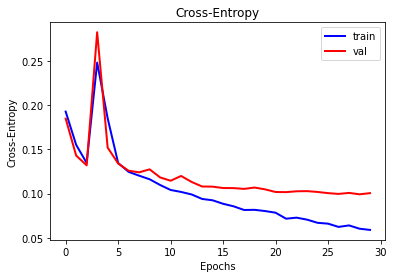

In [61]:
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Criminals classifier')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend(loc='upper right')
plt.title('Cross-Entropy')
plt.show()

### F1 score

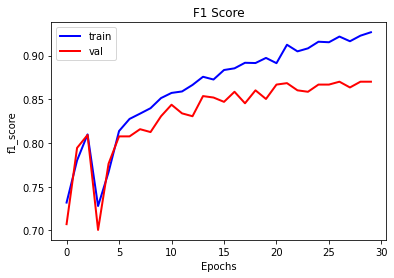

In [62]:
plt.figure()
plt.plot(hist.history['f1_m'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Criminals classifier')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend(loc='upper left')
plt.title('F1 Score')
plt.show()

### Curva ROC

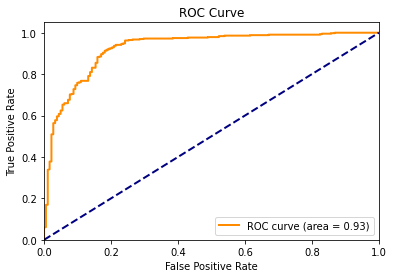

In [ ]:
Y_pred = modelo.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Matriz de Confusão


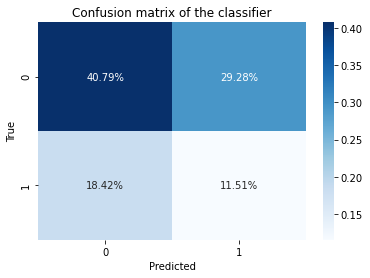

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred)
Y_pred = Y_pred.astype(int)
    
Y_test_tmp = []
for i in Y_test:
    if i[0] == 0:
        Y_test_tmp.append(0)
    else:            
        Y_test_tmp.append(1)

Y_pred_tmp = []
for i in Y_pred:
    if i[0] == 0:
        # Y_pred_tmp.append('crime')
        Y_pred_tmp.append(0)
    else:            
        # Y_pred_tmp.append('naocrime')
        Y_pred_tmp.append(1)
        
    #mc = confusion_matrix(Y_test_tmp, Y_pred_tmp)
    #print (mc)
    
    #from sklearn.metrics import confusion_matrix

labels = ['crime', 'naocrime']
cm = confusion_matrix(Y_test_tmp, Y_pred_tmp)
# 1-sns.heatmap(cm, annot=True)
# 2- sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
# sns.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16})
sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap="Blues")
#print(cm)
#fig = plt.figure()
#ax = fig.add_subplot(111)
#cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
#fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#============= Plot Matrix de confusão =============#

### Arquitetura da Rede

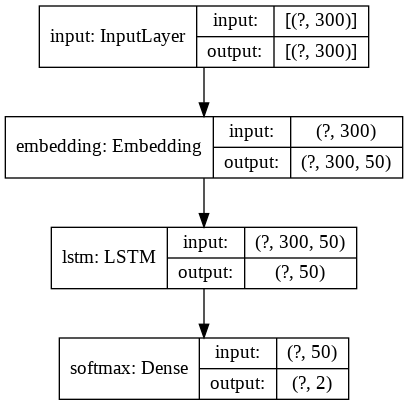

In [91]:
from keras.utils.vis_utils import plot_model
plot_model(modelo, 
           to_file='model_plot.png', 
           show_shapes=True, 
           show_layer_names=True)

In [92]:
print(modelo.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 50)           298350    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                20200     
_________________________________________________________________
softmax (Dense)              (None, 2)                 102       
Total params: 318,652
Trainable params: 20,302
Non-trainable params: 298,350
_________________________________________________________________
None


In [90]:
'''
# Arquitetura da nossa rede
from ann_visualizer.visualize import ann_viz;
from keras.models import model_from_json
import numpy

# fix random seed for reproducibility
numpy.random.seed(7)

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("model.h5")

ann_viz(model, title="Artificial Neural network - Model Visualization")
'''

'\n# Arquitetura da nossa rede\nfrom ann_visualizer.visualize import ann_viz;\nfrom keras.models import model_from_json\nimport numpy\n\n# fix random seed for reproducibility\nnumpy.random.seed(7)\n\n# load json and create model\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\n\nmodel = model_from_json(loaded_model_json)\n\n# load weights into new model\nmodel.load_weights("model.h5")\n\nann_viz(model, title="Artificial Neural network - Model Visualization")\n'